# Table of Contents

- [Business Understanding](#Business-Understanding)
- [Data Understanding](#Data-Understanding)
    * [Calendar Data](#Calendar-Data)
    * [Listings Data](#Listings-Data)
    * [Reviews Data](#Reviews-Data)
- [Data Preparation](#Data-Preparation)
    * [Availability Calculation](#Availability-Calculation)
    * [Remove Unnecessary Columns](#Remove-Unnecessary-Columns)
    * [Fix Column Data Types](#Fix-Column-Data-Types)
    * [Encode Categorical Data](#Encode-Categorical-Data)
    * [Handle Missing Values](#Handle-Missing-Values)
- [Data Modeling](#Data-Modeling)
    * [Linear Regression](#Linear-Regression)
    * [Coefficients](#Coefficients)
- [Results](#Results)

## Business Understanding

In this project, we examine the Seattle Airbnb [dataset](https://www.kaggle.com/airbnb/seattle) in order to gain insight into factors that affect the popularity of a listing. In particular, we want to answer the following questions:
1. Can we build a linear regression model to accurately predict the popularity of a listing?
2. What are the top characteristics of a listing that impact the popularity of a listing?
3. Are there specific neighborhoods or property types that are preferred in a listing?

The accompanying Medium article is [here](https://medium.com/@cheuk.lau/a-data-centric-look-into-seattle-airbnb-22fb137dee3).

## Data Understanding

In this section, we explore the three datasets. We start by importing the three datasets into pandas dataframes.

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Read in data into a Pandas datafram
df_calendar = pd.read_csv('./raw_data/calendar.csv')
df_listings = pd.read_csv('./raw_data/listings.csv')
df_reviews  = pd.read_csv('./raw_data/reviews.csv')

### Calendar Data

Summary:

Each row shows if a listing was available on a given date along with the listed price.

Observations:

- The price column is redundant as its provided in the listing data.
- The date column should be converted to datetime format.
- The available column should be converted to bool format.

In [ ]:
df_calendar.head()

In [ ]:
df_calendar.dtypes

In [ ]:
df_calendar.shape

In [ ]:
df_calendar.isnull().sum()

In [ ]:
df_calendar[df_calendar['available']=='f'].count()

### Listings Data

Summary:

Each row provides the data (e.g., description, neighborhood, price, reviews) and metadata (e.g., ID, listing URL) of a particular listing. 

Observations:

- We can remove many irrelevant metadata columns (e.g., listing_url, scrape_id).
- We can remove columns with a majority of missing values.
- We will have to be careful about proper type conversions of remaining columns.
- In this study we will ignore text-based columns (e.g., name, summary, space); however future work can categorize top key words as additional features.

In [ ]:
df_listings.head()

In [ ]:
df_listings.dtypes.head()

In [ ]:
df_listings.shape

In [ ]:
df_listings.isnull().mean().sort_values(ascending=False).head()

### Reviews Data

Summary:

Each row represents a particular review for a given listing.

Observations:

- We will ignore this dataset since we are interested in the aggregate review response (e.g., review_scores_rating column in the listings dataset) per listing rather than individual reviews.

In [ ]:
df_reviews.head()

In [ ]:
df_reviews.dtypes

In [ ]:
df_reviews.shape

In [ ]:
df_reviews.isnull().mean().sort_values(ascending=False)

## Data Preparation

### Availability Calculation

Our first objective is to calculate the percentage of the dates that each listing was booked. We will append this as another column in the listing dataframe.

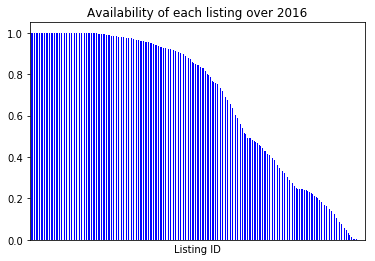

In [419]:
# Replace availability column with Boolean
df_calendar_bool = df_calendar.replace({'available': {'t': True, 'f': False}})

# Availability by listing
# Note: this returns a Pandas series
series_calendar_availability_by_listing = df_calendar_bool.groupby(['listing_id']).mean()['available'].sort_values(ascending=False)

# Verify that the min and max dates of each listing are similar
series_calendar_availability_by_listing.plot(kind="bar", color='b');
plt.title("Availability of each listing over 2016");
plt.xlabel("Listing ID")
plt.xticks([]);

In order for the above to be valid, we need to show that the time range is the same for all listings.

In [ ]:
if df_calendar.groupby(['listing_id']).count()['date'].max() == df_calendar.groupby(['listing_id']).count()['date'].min():
    print "Each listing had data over the entire year"
else:
    print "The time range varied"

Next we add the availability as a column to the listings dataframe, and remove any listing that does not have the availability.

In [3]:
# Convert series to dataframe and rename columns to match listing data
df_calendar_availability_by_listing = series_calendar_availability_by_listing.to_frame().reset_index()
df_calendar_availability_by_listing.columns = ['id', 'availability']
df_calendar_availability_by_listing.head()

,id,availability
0,4026757,1.0
1,4324317,1.0
2,4384095,1.0
3,4395349,1.0
4,4395502,1.0


In [4]:
# Merge the availability dataframe with the listings dataframe
df_listing_with_availability = pd.merge(df_listings, df_calendar_availability_by_listing, on='id')
df_listing_with_availability.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,availability
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07,0.947945
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,f,NaN,WASHINGTON,f,strict,t,t,6,1.48,0.797260
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,f,NaN,WASHINGTON,f,strict,f,f,2,1.15,0.602740
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN,0.391781
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,f,NaN,WASHINGTON,f,strict,f,f,1,0.89,1.000000


### Remove Unnecessary Columns

We start by removing all of the columns that have no apparent impact on availability. This includes metadata (i.e., URLs) and certain location parameters (since all listings are in Seattle).

In [5]:
# List of columns that have no impact
cols_to_remove = ['listing_url', 'scrape_id', 'last_scraped',
                'thumbnail_url', 'medium_url', 'picture_url',
                'xl_picture_url', 'host_id', 'host_name', 
                'host_url', 'host_location', 'host_thumbnail_url', 
                'host_picture_url', 'city', 'state', 'zipcode', 
                'market', 'smart_location', 'country_code', 
                'country', 'latitude', 'longitude', 'is_location_exact', 
                'calendar_updated', 'has_availability', 'availability_30', 
                'availability_60', 'availability_90', 'availability_365',
                'calendar_last_scraped', 'jurisdiction_names']

df_listing_with_availability_drop_irrelevant = df_listing_with_availability.drop(cols_to_remove, axis=1)
df_listing_with_availability_drop_irrelevant.head()

,id,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,host_since,...,review_scores_value,requires_license,license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,availability
0,241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,2011-08-11,...,10.0,f,NaN,f,moderate,f,f,2,4.07,0.947945
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",2013-02-21,...,10.0,f,NaN,f,strict,t,t,6,1.48,0.797260
2,3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...,2014-06-12,...,10.0,f,NaN,f,strict,f,f,2,1.15,0.602740
3,7421966,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,NaN,NaN,2013-11-06,...,NaN,f,NaN,f,flexible,f,f,1,NaN,0.391781
4,278830,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,Belltown,The nearest public transit bus (D Line) is 2 b...,2011-11-29,...,9.0,f,NaN,f,strict,f,f,1,0.89,1.000000


Next we drop all the columns where at least half the listings have null values.

In [6]:
# Find all columns that have more than 50% null values
df_all_columns = df_listing_with_availability_drop_irrelevant.isnull().mean().to_frame().reset_index();
df_all_columns.columns = ['property', 'percent_empty']
df_empty_columns = df_all_columns[df_all_columns['percent_empty'] > 0.5]
df_empty_columns.sort_values(by='percent_empty', ascending=False)

,property,percent_empty
54,license,1.000000
33,square_feet,0.974594
36,monthly_price,0.602672
37,security_deposit,0.511262


In [7]:
# Remove the mostly empty columns from above
df_listing_with_no_empty_columns = df_listing_with_availability_drop_irrelevant.drop(df_empty_columns['property'], axis=1)
df_listing_with_no_empty_columns.head()

,id,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,host_since,...,review_scores_location,review_scores_value,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,availability
0,241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,2011-08-11,...,9.0,10.0,f,f,moderate,f,f,2,4.07,0.947945
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",2013-02-21,...,10.0,10.0,f,f,strict,t,t,6,1.48,0.797260
2,3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...,2014-06-12,...,10.0,10.0,f,f,strict,f,f,2,1.15,0.602740
3,7421966,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,NaN,NaN,2013-11-06,...,NaN,NaN,f,f,flexible,f,f,1,NaN,0.391781
4,278830,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,Belltown,The nearest public transit bus (D Line) is 2 b...,2011-11-29,...,9.0,9.0,f,f,strict,f,f,1,0.89,1.000000


Next we remove text-based (paragraph) columns which are outside the scope of this study. Future work can use keywords from these columns as additional features.

In [15]:
text_based_cols = ['name', 'summary', 'space', 'description', 
                  'neighborhood_overview', 'notes', 'transit',
                  'host_about', 'host_verifications', 'street', 'amenities',
                  'experiences_offered']

df_listing_with_no_free_text = df_listing_with_no_empty_columns.drop(text_based_cols, axis=1)
df_listing_with_no_free_text.head()

,id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_has_profile_pic,...,review_scores_location,review_scores_value,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,availability
0,241032,2011-08-11,within a few hours,96%,100%,f,Queen Anne,3.0,3.0,t,...,9.0,10.0,f,f,moderate,f,f,2,4.07,0.947945
1,953595,2013-02-21,within an hour,98%,100%,t,Queen Anne,6.0,6.0,t,...,10.0,10.0,f,f,strict,t,t,6,1.48,0.797260
2,3308979,2014-06-12,within a few hours,67%,100%,f,Queen Anne,2.0,2.0,t,...,10.0,10.0,f,f,strict,f,f,2,1.15,0.602740
3,7421966,2013-11-06,NaN,NaN,NaN,f,Queen Anne,1.0,1.0,t,...,NaN,NaN,f,f,flexible,f,f,1,NaN,0.391781
4,278830,2011-11-29,within an hour,100%,NaN,f,Queen Anne,2.0,2.0,t,...,9.0,9.0,f,f,strict,f,f,1,0.89,1.000000


We also remove the extra neighborhood columns, and just keep the cleaned one they provided.

In [112]:
pd.set_option('max_columns', None)
redundant_neighborhood_cols = ['host_neighbourhood', 'neighbourhood',
                               'neighbourhood_cleansed']

df_listing_final_removed = df_listing_with_no_free_text.drop(redundant_neighborhood_cols, axis=1)
df_listing_final_removed.head()

,id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,weekly_price,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,availability
0,241032,2011-08-11,within a few hours,96%,100%,f,3.0,3.0,t,t,Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,$85.00,NaN,NaN,2,$5.00,1,365,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,f,moderate,f,f,2,4.07,0.947945
1,953595,2013-02-21,within an hour,98%,100%,t,6.0,6.0,t,t,Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,$150.00,"$1,000.00",$40.00,1,$0.00,2,90,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,strict,t,t,6,1.48,0.797260
2,3308979,2014-06-12,within a few hours,67%,100%,f,2.0,2.0,t,t,Queen Anne,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,$975.00,NaN,$300.00,10,$25.00,4,30,20,2014-07-30,2015-09-03,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,strict,f,f,2,1.15,0.602740
3,7421966,2013-11-06,NaN,NaN,NaN,f,1.0,1.0,t,t,Queen Anne,Apartment,Entire home/apt,3,1.0,0.0,2.0,Real Bed,$100.00,$650.00,NaN,1,$0.00,1,1125,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,flexible,f,f,1,NaN,0.391781
4,278830,2011-11-29,within an hour,100%,NaN,f,2.0,2.0,t,t,Queen Anne,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,$450.00,NaN,$125.00,6,$15.00,1,1125,38,2012-07-10,2015-10-24,92.0,9.0,9.0,10.0,10.0,9.0,9.0,f,f,strict,f,f,1,0.89,1.000000


### Fix Column Data Types

The next step is to make sure all the columns are of the correct data type. We will deal with categorical and missing data in the next few sections.

In [18]:
df_listing_final_removed.dtypes

id                                    int64
host_since                           object
host_response_time                   object
host_response_rate                   object
host_acceptance_rate                 object
host_is_superhost                    object
host_listings_count                 float64
host_total_listings_count           float64
host_has_profile_pic                 object
host_identity_verified               object
neighbourhood_group_cleansed         object
property_type                        object
room_type                            object
accommodates                          int64
bathrooms                           float64
bedrooms                            float64
beds                                float64
bed_type                             object
price                                object
weekly_price                         object
cleaning_fee                         object
guests_included                       int64
extra_people                    

We first convert dates from type object to the number of days before the last day of the dataset (1/4/2017). This gives more weight to listings that have been around longer and have older reviews. Alternatively, we could encode the month, day and year if we think the time of the year influences availability but this seems unlikely. The columns will have type float since they will be normalized. 

In [113]:
date_cols = ['host_since', 'first_review', 'last_review']
for col in date_cols:
    df_listing_final_removed[col] = pd.to_datetime(df_listing_final_removed[col])
    df_listing_final_removed[col] = (pd.to_datetime('2017-1-4') - df_listing_final_removed[col]).dt.days
    max_value = np.nanmax(df_listing_final_removed[col])
    min_value = np.nanmin(df_listing_final_removed[col])
    df_listing_final_removed[col] = (df_listing_final_removed[col] - min_value) / (max_value - min_value)

Next we convert all of the percent object types from string to float.

In [114]:
percent_cols = ['host_response_rate', 'host_acceptance_rate']
for col in percent_cols:
    df_listing_final_removed[col] = df_listing_final_removed[col].str.rstrip('%').astype('float')/100.0

Next we convert all of the t/f columns to data type boolean.

In [115]:
bool_cols = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
            'requires_license', 'instant_bookable', 'require_guest_profile_picture',
            'require_guest_phone_verification']

for col in bool_cols:
    df_listing_final_removed = df_listing_final_removed.replace({col: {'t': True, 'f': False}})

Next we convert all of the price columns to type float which will also be normalized.

In [116]:
price_cols = ['price', 'weekly_price', 'cleaning_fee', 'extra_people']

for col in price_cols:
    df_listing_final_removed[col] = df_listing_final_removed[col].str.lstrip('$').str.replace(',', '').astype('float')
    max_value = np.nanmax(df_listing_final_removed[col])
    min_value = np.nanmin(df_listing_final_removed[col])
    df_listing_final_removed[col] = (df_listing_final_removed[col] - min_value) / (max_value - min_value)

Next we encode all of the categorical columns. First we determine the number of categories, and, if acceptable, we create a new column for each category with a 1 if the listing had that category otherwise 0. Note: null entries (nan) will always be 0.

In [117]:
categorical_cols = ['host_response_time', 'neighbourhood_group_cleansed', 'property_type',
                   'room_type', 'bed_type', 'cancellation_policy']

for col in categorical_cols:
    print '{} has {} categories'.format(col, np.sum(df_listing_final_removed[col].nunique()))

host_response_time has 4 categories
neighbourhood_group_cleansed has 17 categories
property_type has 16 categories
room_type has 3 categories
bed_type has 5 categories
cancellation_policy has 3 categories


The above analysis shows that we would have to add 42 columns (nans are included in the above results as a separate category which we will ignore) which would produce 79 total columns. This results in roughly 3818/79=48 data points per column which is acceptable. Therefore, we will allow all of the categorical columns to be encoded.

In [118]:
for col in categorical_cols:
    df_listing_final_removed = pd.concat([df_listing_final_removed.drop(col, axis=1), 
                                          pd.get_dummies(df_listing_final_removed[col], 
                                                         prefix=col, 
                                                         prefix_sep='_', 
                                                         drop_first=True, 
                                                         dummy_na=False)], 
                                         axis=1)

In [79]:
df_listing_final_removed.head()

,id,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,weekly_price,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,availability,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,neighbourhood_group_cleansed_Beacon Hill,neighbourhood_group_cleansed_Capitol Hill,neighbourhood_group_cleansed_Cascade,neighbourhood_group_cleansed_Central Area,neighbourhood_group_cleansed_Delridge,neighbourhood_group_cleansed_Downtown,neighbourhood_group_cleansed_Interbay,neighbourhood_group_cleansed_Lake City,neighbourhood_group_cleansed_Magnolia,neighbourhood_group_cleansed_Northgate,neighbourhood_group_cleansed_Other neighborhoods,neighbourhood_group_cleansed_Queen Anne,neighbourhood_group_cleansed_Rainier Valley,neighbourhood_group_cleansed_Seward Park,neighbourhood_group_cleansed_University District,neighbourhood_group_cleansed_West Seattle,property_type_Bed & Breakfast,property_type_Boat,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_House,property_type_Loft,property_type_Other,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,room_type_Private room,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_moderate,cancellation_policy_strict
0,241032,0.615326,0.96,1.0,False,3.0,3.0,True,True,4,1.0,1.0,1.0,0.066327,NaN,NaN,2,0.016667,1,365,207,0.634736,0.000637,95.0,10.0,10.0,10.0,10.0,9.0,10.0,False,False,False,False,2,4.07,0.947945,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,953595,0.400766,0.98,1.0,True,6.0,6.0,True,True,4,1.0,1.0,1.0,0.132653,0.145161,0.118644,1,0.000000,2,90,43,0.361100,0.003187,96.0,10.0,10.0,10.0,10.0,10.0,10.0,False,False,True,True,6,1.48,0.797260,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,3308979,0.218391,0.67,1.0,False,2.0,2.0,True,True,11,4.5,5.0,7.0,0.974490,NaN,1.000000,10,0.083333,4,30,20,0.217409,0.077757,97.0,10.0,10.0,10.0,10.0,10.0,10.0,False,False,False,False,2,1.15,0.602740,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1
3,7421966,0.301916,NaN,NaN,False,1.0,1.0,True,True,3,1.0,0.0,2.0,0.081633,0.088710,NaN,1,0.000000,1,1125,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,1,NaN,0.391781,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,278830,0.573180,1.00,NaN,False,2.0,2.0,True,True,6,2.0,3.0,3.0,0.438776,NaN,0.406780,6,0.050000,1,1125,38,0.529779,0.045252,92.0,9.0,9.0,10.0,10.0,9.0,9.0,False,False,False,False,1,0.89,1.000000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1


In [78]:
df_listing_final_removed.shape

(3818, 79)

### Handle Missing Values

The final step for data preparation is to deal with the missing values in each column. First lets find all the columns with missing values, and then decide how to handle them:

- weekly_price: remove this column since there are 1809 missing values which just missed the 50% cutoff we imposed earlier
- cleaning_fee: replace missing values with 0
- host_acceptance_rate: replace missing values with 0
- reviews*: replace missing values with the median (5)
- last_review/reviews_per_month/first_review: remove rows with all three missing since they have no impact on the study
- host_response_rate: replace missing values with 0
- bathrooms/bedrooms/beds: replace missing values with the mean
- host_listings_count/host_total_listings_count: replace missing values with 1
- host_identity_verified/host_is_superhost/host_has_profile_pic: replace missing values with False
- host_since: remove listing if missing

In [125]:
df_listing_final_removed.isnull().sum().sort_values(ascending=False)

review_scores_checkin                               658
review_scores_accuracy                              658
review_scores_value                                 656
review_scores_location                              655
review_scores_cleanliness                           653
review_scores_communication                         651
review_scores_rating                                647
reviews_per_month                                   627
last_review                                         627
first_review                                        627
bathrooms                                            16
bedrooms                                              6
host_is_superhost                                     2
host_listings_count                                   2
host_total_listings_count                             2
host_has_profile_pic                                  2
host_since                                            2
host_identity_verified                          

In [119]:
# Remove weekly_price column
df_listing_final_removed = df_listing_final_removed.drop('weekly_price', axis=1)

In [126]:
# Replace missing values with zero
replace_with_zero_cols = ['cleaning_fee', 'host_acceptance_rate', 'host_response_rate']

for col in replace_with_zero_cols:
    df_listing_final_removed[col].fillna(0, inplace=True)

In [128]:
# Replace missing reviews with median (5)
replace_with_median_cols = ['review_scores_checkin', 'review_scores_accuracy',
                          'review_scores_value', 'review_scores_location',
                          'review_scores_cleanliness', 'review_scores_communication',
                          'review_scores_rating']

for col in replace_with_median_cols:
    df_listing_final_removed[col].fillna(5.0, inplace=True)

In [130]:
# Remove listings without first_review, last_review and reviews_per_month
# Note: if one is missing then all three are missing for that listing
# This also got rid of all missing values in host_listing_count/host_total_listing_count/
# host_identity_verified/host_is_superhost/host_has_profile_pic/host_since
df_listing_final_removed.dropna(subset=['first_review'], axis=0, inplace=True)

In [137]:
# Replace missing values in bathrooms and bedrooms with the mean
replace_with_mean_cols = ['bathrooms', 'bedrooms']

for col in replace_with_mean_cols:
    df_listing_final_removed[col].fillna(df_listing_final_removed[col].mean(), axis=0, inplace=True)

In [213]:
# Finally drop the id column
df_listing_final_removed.drop(['id'], inplace=True, axis=1)

In [214]:
df_listing_final_removed.head()

,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,availability,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,neighbourhood_group_cleansed_Beacon Hill,neighbourhood_group_cleansed_Capitol Hill,neighbourhood_group_cleansed_Cascade,neighbourhood_group_cleansed_Central Area,neighbourhood_group_cleansed_Delridge,neighbourhood_group_cleansed_Downtown,neighbourhood_group_cleansed_Interbay,neighbourhood_group_cleansed_Lake City,neighbourhood_group_cleansed_Magnolia,neighbourhood_group_cleansed_Northgate,neighbourhood_group_cleansed_Other neighborhoods,neighbourhood_group_cleansed_Queen Anne,neighbourhood_group_cleansed_Rainier Valley,neighbourhood_group_cleansed_Seward Park,neighbourhood_group_cleansed_University District,neighbourhood_group_cleansed_West Seattle,property_type_Bed & Breakfast,property_type_Boat,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_House,property_type_Loft,property_type_Other,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,room_type_Private room,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_moderate,cancellation_policy_strict
0,0.615326,0.96,1.0,False,3.0,3.0,True,True,4,1.0,1.0,1.0,0.066327,0.000000,2,0.016667,1,365,207,0.634736,0.000637,95.0,10.0,10.0,10.0,10.0,9.0,10.0,False,False,False,False,2,4.07,0.947945,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,0.400766,0.98,1.0,True,6.0,6.0,True,True,4,1.0,1.0,1.0,0.132653,0.118644,1,0.000000,2,90,43,0.361100,0.003187,96.0,10.0,10.0,10.0,10.0,10.0,10.0,False,False,True,True,6,1.48,0.797260,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,0.218391,0.67,1.0,False,2.0,2.0,True,True,11,4.5,5.0,7.0,0.974490,1.000000,10,0.083333,4,30,20,0.217409,0.077757,97.0,10.0,10.0,10.0,10.0,10.0,10.0,False,False,False,False,2,1.15,0.602740,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1
4,0.573180,1.00,0.0,False,2.0,2.0,True,True,6,2.0,3.0,3.0,0.438776,0.406780,6,0.050000,1,1125,38,0.529779,0.045252,92.0,9.0,9.0,10.0,10.0,9.0,9.0,False,False,False,False,1,0.89,1.000000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1
5,0.703065,0.00,0.0,False,1.0,1.0,True,True,2,1.0,1.0,1.0,0.102041,0.118644,1,0.100000,1,6,17,0.085798,0.061823,95.0,10.0,10.0,10.0,10.0,10.0,10.0,False,False,False,False,1,2.45,0.827397,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1


In [138]:
# Verify no more missing data
df_listing_final_removed.isnull().sum().sort_values(ascending=False)

cancellation_policy_strict                          0
review_scores_value                                 0
last_review                                         0
review_scores_rating                                0
review_scores_accuracy                              0
review_scores_cleanliness                           0
review_scores_checkin                               0
review_scores_communication                         0
review_scores_location                              0
requires_license                                    0
number_of_reviews                                   0
instant_bookable                                    0
require_guest_profile_picture                       0
require_guest_phone_verification                    0
calculated_host_listings_count                      0
reviews_per_month                                   0
availability                                        0
host_response_time_within a day                     0
first_review                

## Data Modeling

### Linear Regression

In this section we will use sklearn to build a linear regression model using the data we created in the previous section. We will use it to predict listing availability. The lower the availability, the more the listing was occupied during the date range provided (1/4/2016 to 1/4/2017).

In [142]:
# Import required libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [345]:
# Create feature matrix and response vector
X = df_listing_final_removed.drop(['availability'], axis=1)
y = df_listing_final_removed['availability']

def perform_fit(X, y, test_size=0.3, random_state=42):
    '''
    INPUT:
    X            - feature matrix
    y            - response vector
    test_size    - test size
    random_state - random state to produce identical results
    OUTPUT:
    r2_test      - r2 score of the predicted test vector
    r2_train     - r2 score of the predicted training vector
    linear_model - linear regression model
    Fits a linear regression model on the provided feature matrix and response vector
    using a specified test-train splitting.
    '''
        
    # Split into training and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=test_size, 
                                                        random_state=random_state)

    # Fit a linear model
    linear_model = LinearRegression(normalize=True)
    linear_model.fit(X_train, y_train)

    # Generate the predicted test results
    y_test_prediction = linear_model.predict(X_test)
    r2_test = r2_score(y_test, y_test_prediction)

    # Print the results
    # print 'The r2 score of your test predictions is {}'.format(r2_test)

    # Generate the predicted train results
    y_train_prediction = linear_model.predict(X_train)
    r2_train = r2_score(y_train, y_train_prediction)

    # Print the results
    # print 'The r2 score of your training predictions is {}'.format(r2_train)
    
    return linear_model, r2_test, r2_train

# Run the function
_, r2_test, r2_train = perform_fit(X, y)
print 'r2 score for test: {}, r2 score for train: {}'.format(r2_test, r2_train)

r2 score for test: 0.0175178876184, r2 score for train: 0.121433269683


Since the r2 score of the train data is six times higher than the test data, we may be overfitting the model on the train data. We will try to handpick groups of features to remove to see if we can get the r2 scores to converge.

[76, 75, 74, 73, 72, 71, 66, 61, 56, 51, 46, 41, 36, 31, 26, 16, 6]
max r2 score for predicted test is 0.0406610767638


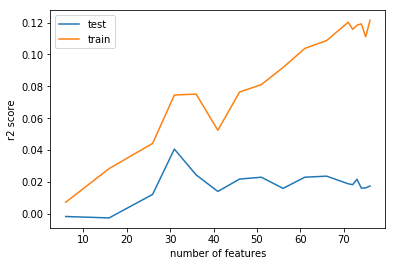

In [373]:
import random

num_features_to_remove = [0, 1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70]

# Initialize r2 score storage
r2_test_total = []
r2_train_total = []

# Initialize linear model and training matrix storage for later use
lm_model_total = []
X_train_total = []

# Create feature matrix and response vector
X = df_listing_final_removed.drop(['availability'], axis=1)
y = df_listing_final_removed['availability']
    
# List of columns
cols_list = list(X.columns)

for num_feature in num_features_to_remove:
    
    # Randomly sample columns to keep
    cols_drop = random.sample(cols_list, num_feature)
    X_shortened = X.drop(cols_drop, axis=1)
    lm_model, r2_test, r2_train = perform_fit(X_shortened, y, 0.3, 42)
    r2_test_total.append(r2_test)
    r2_train_total.append(r2_train)
    lm_model_total.append(lm_model)
    X_train_total.append(X_shortened)

num_features = [len(cols_list) - x for x in num_features_to_remove]
print num_features
plt.plot(num_features, r2_test_total, label='test');
plt.plot(num_features, r2_train_total, label='train');
plt.xlabel('number of features')
plt.ylabel('r2 score')
plt.legend()
print 'max r2 score for predicted test is {}'.format(max(r2_test_total))

By reducing our number of features to 31 we were able to double the r2 score of the test data to approximately 0.041. Further reduction beyond this point led to a decrease in the r2 score for both the training and test data.

### Coefficients

In this section, we use the linear regression coefficients on each variable to determine the features that had the highest impact on our response vector.

In [379]:
def find_weights(lm_model, X_train):
    '''
    INPUT:
    lm_model - linear regression model
    X_train  - feature matrix  of training data
    OUTPUT:
    coefs_df - dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    
    coefs_df = pd.DataFrame()
    coefs_df['est_int']   = X_train.columns
    coefs_df['coefs']     = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

# Generate the coefficients from the full model and display the top 10
coef_df = find_weights(lm_model_total[0], X_train_total[0])
coef_df.head(10)

,est_int,coefs,abs_coefs
4,host_listings_count,1.716276e+10,1.716276e+10
5,host_total_listings_count,-1.716276e+10,1.716276e+10
28,requires_license,2.343628e+09,2.343628e+09
12,price,5.630038e-01,5.630038e-01
43,neighbourhood_group_cleansed_Interbay,3.744652e-01,3.744652e-01
13,cleaning_fee,3.010113e-01,3.010113e-01
6,host_has_profile_pic,2.970005e-01,2.970005e-01
19,first_review,2.412437e-01,2.412437e-01
60,property_type_Dorm,-2.383410e-01,2.383410e-01
35,host_response_time_within a few hours,1.917535e-01,1.917535e-01


The above shows very large (orders of magnitude higher) coefficient for the first three columns. Closer inspection shows that the column 'requires_license' is actually all False. Therefore, we can drop this column as it does not contribute to our model. The first two columns 'host_listings_count' and 'host_total_listings_count' is also interesting in that the coefficients are the same but have opposite signs. Closer inspection shows that both columns actually have identical entries. Therefore, we will drop one of them. Let's repeat the analysis above with the two columns of interest dropped.

In [400]:
cols_drop = ['host_total_listings_count', 'requires_license']
X_corrected = X.drop(cols_drop, axis=1)
lm_model_corrected, r2_test_corrected, r2_train_corrected = perform_fit(X_corrected, y)
print 'The r2 score of the test prediction is: {}'.format(r2_test_corrected)
print 'The r2 score of the training prediction is: {}'.format(r2_train_corrected)
coef_df = find_weights(lm_model, X_shortened)
coef_df.head(10)

The r2 score of the test prediction is: 0.0173259166565
The r2 score of the training prediction is: 0.121429348946


,est_int,coefs,abs_coefs
11,price,0.563756,0.563756
41,neighbourhood_group_cleansed_Interbay,0.372537,0.372537
12,cleaning_fee,0.301937,0.301937
5,host_has_profile_pic,0.296863,0.296863
58,property_type_Dorm,-0.245253,0.245253
18,first_review,0.242429,0.242429
33,host_response_time_within a few hours,0.191760,0.191760
34,host_response_time_within an hour,0.187064,0.187064
56,property_type_Chalet,0.181942,0.181942
14,extra_people,0.171371,0.171371


The above top 10 coefficients make a lot of sense when we think about what people care about when deciding on an Airbnb. Recall that the response vector is the availability, so positive coefficients indicate the feature and booking rate are inversely related. We will provide more discussion in the conclusion section.

## Results

In this study, we explored the Airbnb Seattle [dataset](https://www.kaggle.com/airbnb/seattle) that spanned 1/4/2016-1/4/2017. We did a preliminary exploration of the data before preparing it for modeling. Preparation included the following:
- Calculating the availability for each listing over the given time period
- Removing irrelevant metadata columns
- Removing mostly empty columns
- Removing text-based columns (basis for future work as discussed later)
- Accounting for missing values

Next, we built a linear regression model. The full data produced a r2-score of 0.02 for the test data and 0.12 of the train data. This suggested the model may be overfitting the training data. Systematically reducing the number of features doubled the r2-score of the test data to 0.04.

![plot of r2 graph](./images/r2_graph.png)

Lastly, we looked at the coefficients of the linear model to determine the relative impact of each of the features on the response vector (availability). 

![table of coeffs](./images/coeff_table.png)

The results produced the following observations:
- As expected pricing is the highest factor and the higher the price, the less likely a listing was booked.
- Housing in the Interbay neighborhood was undesirable.
- The higher the cleaning fee, the less likely a listing was booked.
- Dorm-style properties were undesirable.
- Listings with older reviews were more likely to be booked.
- Hosts that respond within an hour or within a few hours were more likely to be booked.
- Chalet-style properties were desirable.
- Listings allowing extra people were more likely to be booked.

An unexpected observation was that if a host has a profile pic, then their listings are less likely to get booked. However, further analysis showed that only 5 hosts did not have profile pictures which may have skewed the results. We now return back to our original three questions for this study:
1. Can we build a linear regression model to accurately predict the popularity of a listing?
2. What are the top characteristics of a listing that impact the popularity of a listing?
3. Are there specific neighborhoods or property types that are preferred in a listing?

The answer to the first question is yes. In this study, we produced a fairly poor r2-score (0.04) for the testing data. We believe this score can be drastically improved by using the text-based columns (e.g., listing title, listing summary, etc) with keyword encoding. We can also explore alternative methods such as XGBoost. The answer to the second and third questions can be found in the observations listed above.